SET 2:Review text, preprocessed one converted into vectors using (TFIDF)

Procedure:
* Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.
* You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these bolgs blog-1, blog-2 for more information)
* You should choose the n_components in truncated svd, with maximum explained variance. Please search on how to choose that and implement them. (hint: plot of cumulative explained variance ratio)
* After you are done with the truncated svd, you can apply K-Means clustering and choose the best number of clusters based on elbow method.
* Print out wordclouds for each cluster, similar to that in previous assignment.
* You need to write a function that takes a word and returns the most similar words using cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)

In [1]:
# importing required libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import pickle
from tqdm import tqdm
import os
from collections import Counter

# ============================== loading libraries ===========================================
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import itertools
from wordcloud import WordCloud, STOPWORDS 

import wordcloud
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [2]:
# Loading preprocessed final df
final = pickle.load(open('preprocessed_final', 'rb'))

In [4]:
X = final['CleanedText'].values

**SET 2:Review text, preprocessed one converted into vectors using (TFIDF)**

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

**Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.**

In [5]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 3000)
tf_idf_vect.fit(X) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X)

print("After vectorizations")
print(X_train_tfidf.shape)
print(type(X_train_tfidf))

After vectorizations
(87773, 3000)
<class 'scipy.sparse.csr.csr_matrix'>


In [5]:
print(X_train_tfidf.shape)

(87773, 3000)


In [6]:
length = X_train_tfidf.shape[1]
print(length)

3000


In [7]:
# Get feature names from tfidf vectorizer and not the matrix
tfidf_features = tf_idf_vect.get_feature_names()

# feature weights based on idf score
tfidf_coeff = tf_idf_vect.idf_

In [9]:
type(tfidf_features)

list

In [10]:
len(tfidf_features)

3000

### [5.2] Calulation of Co-occurrence matrix

**You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these bolgs [blog-1](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285), [blog-2](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/) for more information)**




    

In [8]:
# We declare a empty zero matrix with the dimension of length of features
coocr_matrix = np.zeros((length,length))

In [9]:
# let us define the window size 
context_window_size = 5

In [10]:
for sentece in X:
    words = sentece.split()
    for index,word in enumerate(words):
        if word in tfidf_features:
            for j in range(max(index - context_window_size, 0),min(index + context_window_size, len(words)-1) + 1):
                if words[j] in tfidf_features:
                    coocr_matrix[tfidf_features.index(word),tfidf_features.index(words[j])] += 1
                else:
                    continue
        else:
            continue

In [11]:
coocr_matrix

array([[2.553e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 2.000e+00,
        1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.620e+02, 0.000e+00,
        2.000e+00],
       [2.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 5.070e+02,
        0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 2.000e+00, 0.000e+00,
        2.830e+02]])

In [12]:
filename = 'co_occurence_matrix.sav'
pickle.dump(coocr_matrix, open(filename, 'wb'))

In [12]:
coocr_matrix = pickle.load(open(filename, 'rb'))

In [13]:
# TrucatedSVD
from sklearn.decomposition import TruncatedSVD
truncated_svd = TruncatedSVD(n_components = 500)
truncated_svd_data = truncated_svd.fit(coocr_matrix)

In [14]:
# List of explained variances
truncated_svd_data_explained_var_ratio = truncated_svd_data.explained_variance_ratio_

**You should choose the n_components in truncated svd, with maximum explained variance. Please search on how to choose that and implement them. (hint: plot of cumulative explained variance ratio)**

### [5.3] Finding optimal value for number of components (n) to be retained.

In [15]:
# Code referenced: https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd

def select_n_components(var_ratio, goal_var: float) -> int:
    """This function tells us the number of components that explains the desired percentage of explained variance"""
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [16]:
# We want to select the number of n_components that explains about 90% of the variance
select_n_components(truncated_svd_data_explained_var_ratio, .90)

94

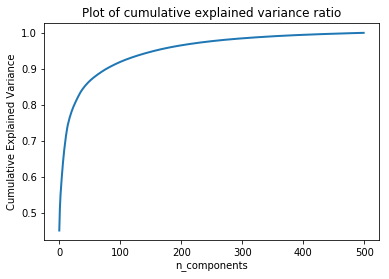

In [17]:
percentage_var_explained = truncated_svd_data.explained_variance_ / np.sum(truncated_svd_data.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

plt.plot(cum_var_explained, linewidth = 2)
plt.title('Plot of cumulative explained variance ratio')
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

**Observation**: We observe that 90% of variance is explained for n_components = 94.

In [18]:
svd_cls = TruncatedSVD(n_components = 94)
svd_data = svd_cls.fit_transform(coocr_matrix)

**After you are done with the truncated svd, you can apply K-Means clustering and choose the best number of clusters based on elbow method.**

### [5.4] Applying k-means clustering

In [19]:
def getKmeansBestK(X_data):
    
    """
    This function takes in the vectorizer data, iterates over a set of k values and draws a elbow plot.
    The y axis represents the sum of distances of samples to their closest cluster center.
    """
    k_values = [1, 3, 5, 11, 21]
    sse = {}   # score
    for k in k_values:
        kmeans = KMeans(n_clusters=k).fit(X_data)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), marker='o')
    plt.title("Determining best k")
    plt.xlabel("Number of cluster")
    plt.ylabel("Loss")
    plt.show()

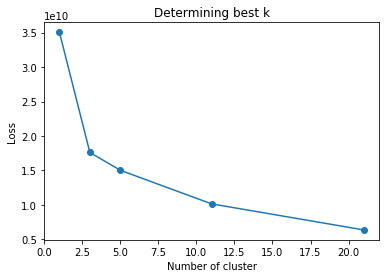

In [20]:
getKmeansBestK(svd_data)

**Observation:** We can see a sharp fall at k = 3. So we will take value of k = 3.

In [21]:
# Implementing k-means 
kmeans_tfidf = KMeans(n_clusters= 3, n_jobs=-1, random_state= 507).fit(svd_data)

In [22]:
result = zip(X , kmeans_tfidf.labels_)

In [23]:
result_df = pd.DataFrame(result)
result_df.rename(columns={0: "CleanedText", 1: "labels"}, inplace= True)
result_df.head()

,CleanedText,labels
0,bought apartment infested fruit flies hours tr...,0
1,really good idea final product outstanding use...,0
2,received shipment could hardly wait try produc...,0
3,nothing product bother link top page buy used ...,0
4,love stuff sugar free not rot gums tastes good...,0


In [53]:
# Number of reviews for each label
result_df['labels'].value_counts()

0    2996
1       3
2       1
Name: labels, dtype: int64

### [5.5] Wordclouds of clusters obtained in the above section

In [24]:
reviews = result_df['CleanedText'].values

# Creating empty lists to store reviews based on the label
cluster0 = []
cluster1 = []
cluster2 = []

# for every corresponding label, we will append each review to their respecitve cluster list
for i in range(kmeans_tfidf.labels_.shape[0]):
    if kmeans_tfidf.labels_[i] == 0:
        cluster0.append(reviews[i])
        
    elif kmeans_tfidf.labels_[i] == 1:
        cluster1.append(reviews[i])
             
    else :
        cluster2.append(reviews[i]) 

cluster0_str = ('').join(cluster0)
cluster1_str = ('').join(cluster1)
cluster2_str = ('').join(cluster2)

cluster_str = [cluster0_str, cluster1_str, cluster2_str]

**Print out wordclouds for each cluster, similar to that in previous assignment.**

In [60]:
def plot_WordCloud(txt, ind):
    
    """
    This function takes text as string and plots wordcloud. ind here is for the index of the list element
    """
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(txt)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off") 
    plt.title("World cloud of Cluster {}".format(ind))
    plt.tight_layout(pad = 0)
  
    plt.show()

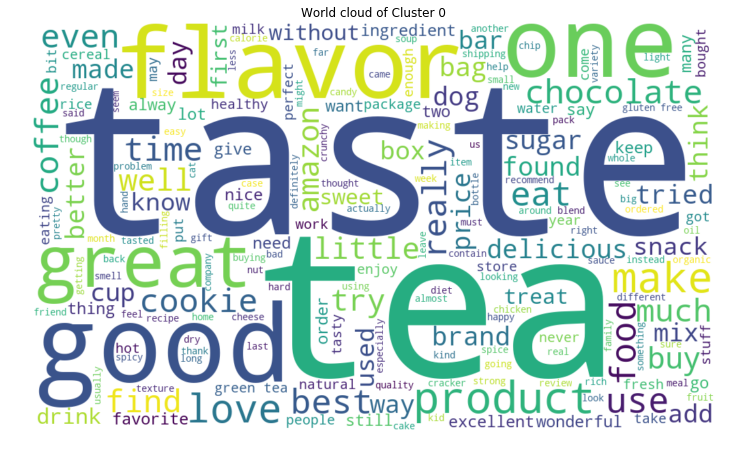

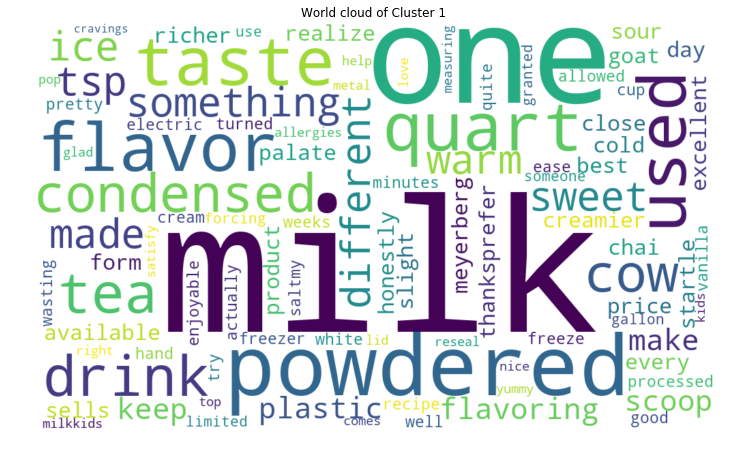

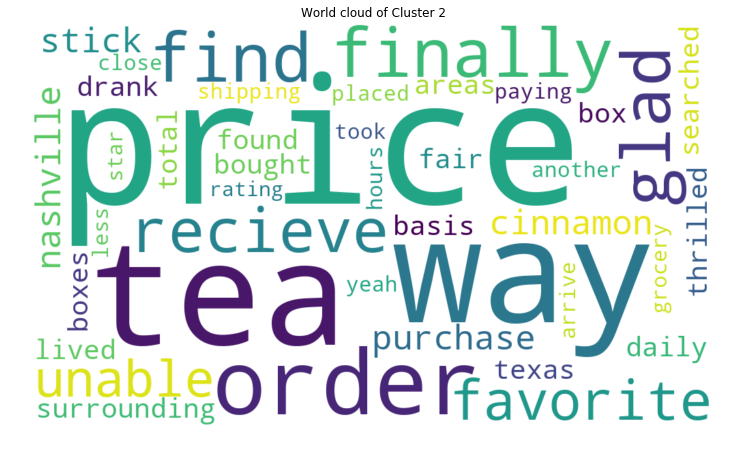

In [61]:
for ind, cluster in enumerate(cluster_str):
    plot_WordCloud(cluster, ind)

### [5.6] Function that returns most similar words for a given word.

**You need to write a function that takes a word and returns the most similar words using cosine similarity between the vectors (vector: a row in the matrix after truncatedSVD)**

In [25]:
from sklearn.metrics.pairwise import linear_kernel

In [26]:
# Code Reference: # Reference code: https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity?answertab=votes#tab-top
def get_similar_word(word, n = 5):
    """This function takes a word and returns n similar words"""
    word_index = tfidf_features.index(word)
    cosine_similarities = linear_kernel(svd_data[[word_index]], svd_data).flatten()
    related_docs_indices = cosine_similarities.argsort()[::-1][1:n+1] # skipping 0 because it will return the same word
    for indices in related_docs_indices:
        print(tfidf_features[indices])

In [27]:
get_similar_word('happy')

like
good
product
taste
great


**Summary**
1. We selected **top 3000 features** from Amazon Fine Food reviews using **Tf-idf vectorizer**.
2. We calculated word vectors using co-occurence matrix by condiering **context window size of 5**.
3. We used elbow method to determine **n_components for TruncatedSVD** and the optimal value observed was **94**.
4. From this value of n_components, we performed unsupervised **K-means algorithm** on the svd data. We got **3 clusters**
5. We also calculated **cosine similarity** to get n similar word(s) for a given word(index)

**Important Resources**

http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/

https://medium.com/swlh/playing-with-word-vectors-308ab2faa519